In [49]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import odeint, solve_ivp
from scipy.ndimage import laplace

In [2]:
def f(kappa, rho, theta=0):
    return 0.5 + 0.5 * np.tanh(kappa * (rho-theta))

def dydt(t, y, kappa, r=0.2, D=0.05**2, delta=0.01):
    dkappa = kappa[1]-kappa[0]
    rho = np.trapz(y, dx=dkappa)
    pp = f(kappa, rho)
    # rho = np.trapz(pp * y, dx=dkappa)
    dy = D * (1 - rho) * laplace(pp * y) / dkappa ** 2
    dy[0] = D * (1 - rho) * (pp[1] * y[1] - pp[0] * y[0]) / dkappa **2
    dy[-1] = D * (1 - rho) * (pp[-2] * y[-2] - pp[-1] * y[-1]) / dkappa **2
    dy += pp * r * y * (1 - rho) - delta * y
    return dy

def dydt2(t, y, kappa, theta, dkappa, dtheta, r=0.5, Dkappa=0.2**2, Dtheta=0.05**2, delta=0.05):
    y = y.reshape(kappa.shape)
    rho = np.trapz(np.trapz(y, dx=dtheta), dx=dkappa)
    pp = f(kappa, rho, theta)
    fy = pp * y
    # rho = np.trapz(np.trapz(pp * y, dx=dtheta), dx=dkappa)  # resembles more the actual lgca
    dy = np.zeros_like(y)
    dy[1:-1, ...] = Dkappa * (1 - rho) * (fy[0:-2, ...] - 2 * fy[1:-1, ...] + fy[2:, ...]) / dkappa ** 2
    dy[:, 1:-1] += Dtheta * (1 - rho) * (fy[:, 0:-2] - 2 * fy[:, 1:-1] + fy[:, 2:]) / dtheta ** 2
    dy[0, :] = Dkappa * (1 - rho) * (fy[1, :] - fy[0, :]) / dkappa **2
    dy[-1] = Dkappa * (1 - rho) * (fy[-2] - fy[-1]) / dkappa **2
    dy[:, 0] = Dtheta * (1 - rho) * (fy[:, 1] - fy[:, 0]) / dtheta **2
    dy[:, -1] = Dtheta * (1 - rho) * (fy[:, -2] - fy[:, -1]) / dtheta **2
    dy += fy * r * (1 - rho) - delta * y
    return dy.flatten()

In [3]:
kappa, dkappa = np.linspace(-8, 8, 201, retstep=True)
y0 = np.ones_like(kappa) / (kappa[-1] - kappa[0]) * .01
# y0[len(y0)//2] = .1 / dkappa
sol = solve_ivp(dydt, (0, 10000), y0, args=(kappa,))
t = sol.t
y = sol.y

0.9498390356995308


Text(0.5, 1.0, '$\\theta = 1$')

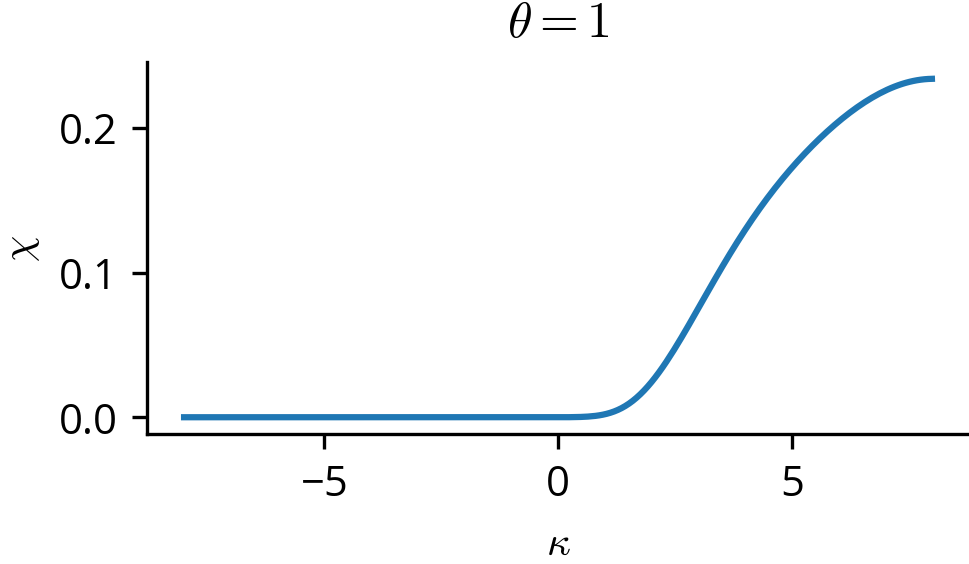

In [4]:
ind = -1
plt.plot(kappa, y[..., ind])
print(np.trapz(y[..., ind], dx=dkappa))
plt.xlabel('$\\kappa$')
plt.ylabel('$\\chi$')
plt.title('$\\theta = 1$')
# plt.savefig('chi_ss_t1.svg')
# plt.plot(kappa, f(kappa, np.trapz(y[..., -1], dx=dkappa)))

In [86]:
np.trapz(y[..., -1], dx=dkappa)

0.9498390356995308

In [5]:
theta, dtheta = np.linspace(0, 1, 101, retstep=True)
kappas, thetas = np.meshgrid(kappa, theta)
y0 = np.ones_like(kappas) / (theta[-1] - theta[0]) / (kappa[-1] - kappa[0]) * 1
# y0[len(kappa)//2, len(theta)//2] = .1 / dkappa / dtheta
y = solve_ivp(dydt2, (0, 5000), y0.flatten(), args=(kappas, thetas, dkappa, dtheta)).y

In [6]:
y[..., -1].shape, kappas.shape

((20301,), (101, 201))

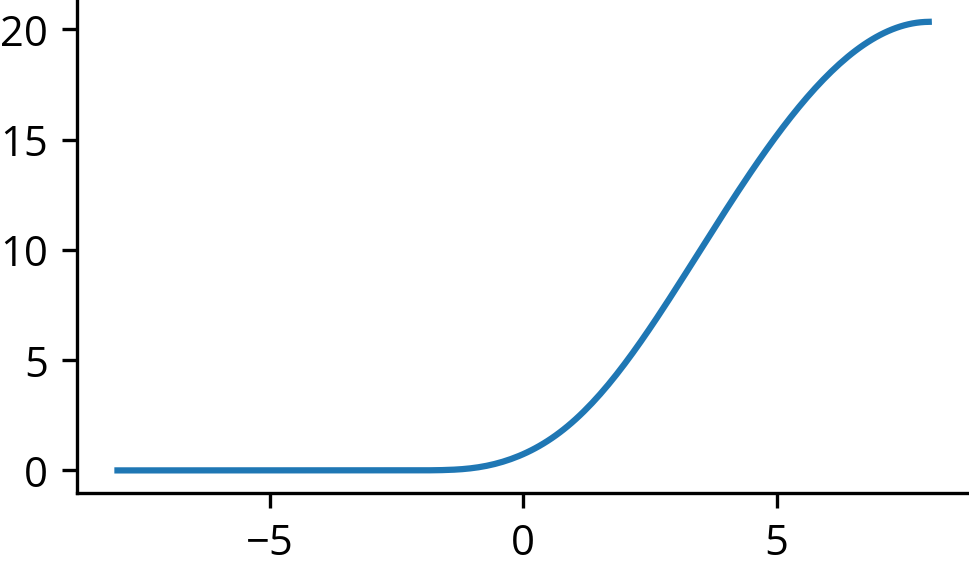

In [7]:
plt.plot(kappa, y[..., -1].reshape(kappas.shape).sum(0))

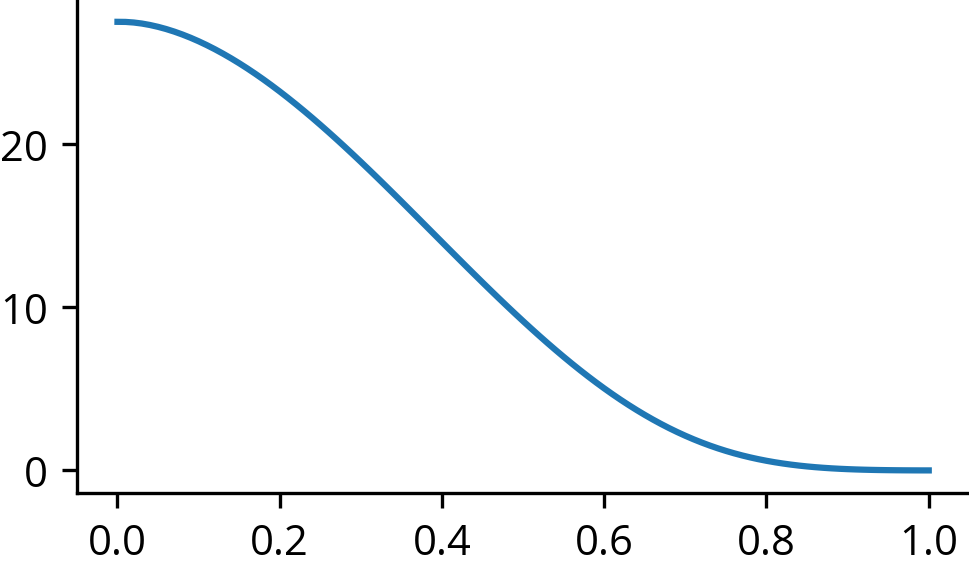

In [8]:
plt.plot(theta, y[..., -1].reshape(kappas.shape).sum(-1))

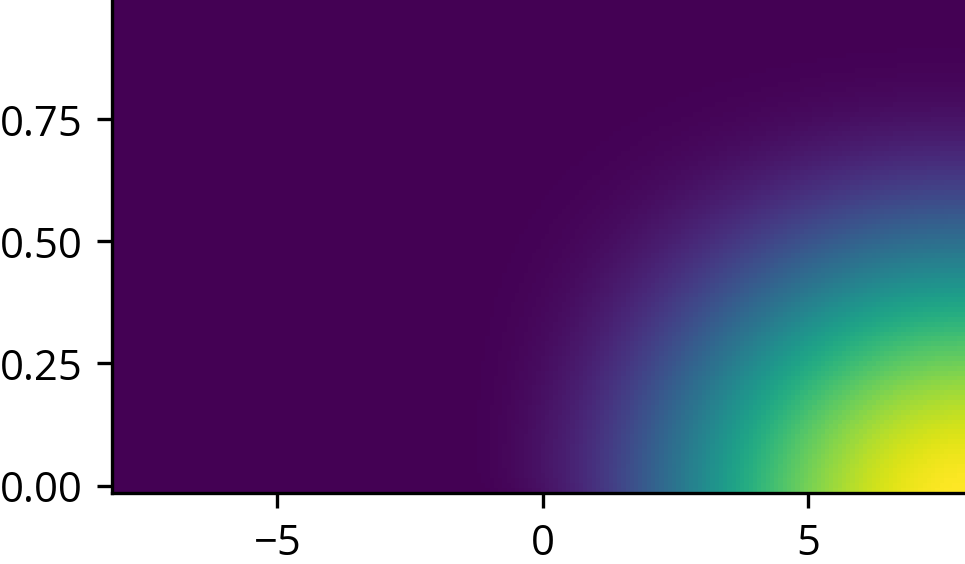

In [9]:
plt.pcolormesh(kappas-dkappa,thetas-dtheta,  y[..., -1].reshape(kappas.shape))

In [10]:
rhofinal = np.trapz(np.trapz(y[..., -1].reshape(kappas.shape), dx=dtheta), dx=dkappa)

In [11]:
rhofinal

0.8976658175034008

0.8976658175034008


Text(0, 0.5, '$\\theta$')

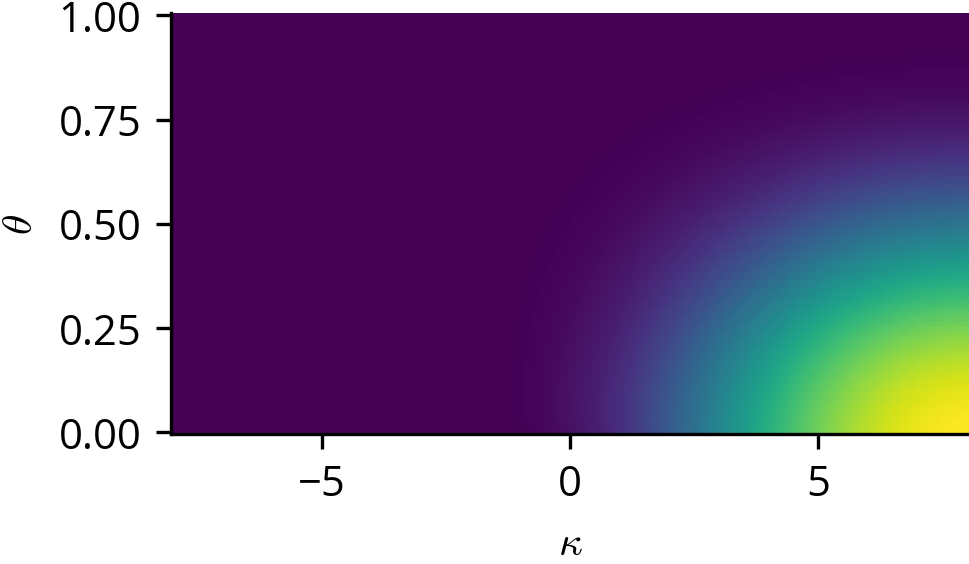

In [12]:
print(np.trapz(np.trapz(y[..., -1].reshape(kappas.shape), dx=dtheta), dx=dkappa))
plt.pcolormesh(kappas, thetas,  y[..., -1].reshape(kappas.shape))
plt.xlabel('$\kappa$')
plt.ylabel('$\\theta$')

In [13]:
y.reshape(kappas.shape + (-1,)).shape

(101, 201, 19400)

In [14]:
kappa, dkappa = np.linspace(-8, 8, 26, retstep=True)
theta, dtheta = np.linspace(0, 1, 26, retstep=True)
kappas, thetas = np.meshgrid(kappa, theta)


rs = f(kappas, 0.5, thetas)
advection = np.gradient(rs, dkappa, dtheta)

In [50]:
# plt.pcolormesh(kappas, thetas,  rs)
# plt.show()

In [51]:
# plt.quiver(kappas, thetas, advection[0],  advection[1])
# plt.xlabel('$\kappa$')
# plt.ylabel('$\\theta$')


In [52]:
# plt.streamplot(kappas, thetas, advection[0], advection[1])
# plt.xlabel('$\kappa$')
# plt.ylabel('$\\theta$')

In [53]:
# geometry
geom = 'hx'
restchannels = 1
l = 150
dims= l, l
capacity = 100
# interaction parameters
r_m = 1e-3 # mutation rate for driver mutations
r_b = 0.1 # initial birth rate
r_d = 0.09 * r_b / 2 # initial death rate

In [54]:
nodes = np.zeros(dims+(6+restchannels,), dtype=int)
nodes[l//2, l//2, -1] = capacity
kappa = np.random.random(capacity) * 8 - 4

In [55]:
lgca = get_lgca(ib=True, bc='reflect', interaction='go_or_grow', dims=dims, nodes=nodes, ve=False, geometry='hx',
                r_b=r_b, capacity=capacity, r_d=r_d, kappa=kappa)

std of kappa set to 0.2
std of theta set to 0.05
switch threshold set to theta =  0.5


In [56]:
lgca.timeevo(1000, record=True)

KeyboardInterrupt: 

In [ ]:
lgca.plot_density(lgca.dens_t[1])